1. Metode yang digunakan: YOLOv8 (You Only Look Once versi 8)

  Alasan Pemilihan:

  - Real-time inference dengan kecepatan tinggi.

  - Akurasi tinggi untuk deteksi objek kecil seperti helm dan rompi.

  - Arsitektur modern dan ringan, cocok untuk implementasi edge (CCTV).

  - Format dataset sudah tersedia (dataset snehilsanyal/construction-site-safety-image-dataset-roboflow menggunakan YOLO format).



# **Import Libary**

In [65]:
!pip install ultralytics

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, shutil, cv2, random
warnings.filterwarnings('ignore')
from ultralytics import YOLO
from tqdm.notebook import tqdm
from collections import Counter, defaultdict

# **Unduh Dataset "Construction Site Safety" dari Kaggle**

In [66]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cucurgeming","key":"ba13766a9302a49b469ac43dcccd320f"}'}

In [67]:
import os
import shutil

# Buat folder .kaggle jika belum ada
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan file kaggle.json ke folder yang benar
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Atur permission agar aman
os.chmod('/root/.kaggle/kaggle.json', 600)

# Unduh dataset Construction Site Safety dari Kaggle
!kaggle datasets download -d snehilsanyal/construction-site-safety-image-dataset-roboflow

# Ekstrak file ZIP ke folder 'construction-site-safety-dataset'
!unzip construction-site-safety-image-dataset-roboflow.zip -d construction-site-safety-dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-25_jpg.rf.0a21e9e91348b61c6c1483d6884d2135.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-25_jpg.rf.3313bb2b19a7aa3a0af745abe858ec8e.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-25_jpg.rf.3bbcfef23f20b2cf747256793dcfc615.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-25_jpg.rf.6cee1b67a21808fad2318593379f9986.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-25_jpg.rf.ddd7840e3d846cddfcc13d99f4a6999b.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-2_jpg.rf.4d46f38425296af74814d1f0506575b4.jpg  
  inflating: construction-site-safety-dataset/css-data/train/images/IMG_3100_mp4-2_jpg.rf.58de1db8826e4221df63fd980b823844.jpg  
  inflating: construction-site-sa

# **Membuat direktori input dan output**

In [87]:
# Jalur dataset sumber
BASE_DIR = "/content/construction-site-safety-dataset/css-data"

In [88]:
# Jalur direktori keluaran
OUTPUT_DIR = '/content/working/yolo_dataset'
IMAGES_DIR = os.path.join(OUTPUT_DIR,'images')
LABELS_DIR = os.path.join(OUTPUT_DIR,'labels')

In [89]:
for split in ['train','val','test']:
    os.makedirs(os.path.join(IMAGES_DIR,split),exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR,split),exist_ok=True)

# **Mengonversi set data ke format YOLO**

In [90]:
from tqdm.notebook import tqdm
for split in ['train', 'valid', 'test']:
    split_new = 'val' if split == 'valid' else split
    img_dir = os.path.join(BASE_DIR, split, 'images')
    lbl_dir = os.path.join(BASE_DIR, split, 'labels')

    for fname in tqdm(os.listdir(img_dir)):
        if fname.endswith(".jpg"):
            # Copy image
            shutil.copy2(os.path.join(img_dir, fname), os.path.join(IMAGES_DIR, split_new, fname))
            # Copy label
            label_name = fname.replace(".jpg", ".txt")
            shutil.copy2(os.path.join(lbl_dir, label_name), os.path.join(LABELS_DIR, split_new, label_name))

  0%|          | 0/2605 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

# **Memvisualisasikan contoh gambar**

In [91]:
def visualize_sample(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts)
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(image, str(int(class_id)), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(10,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

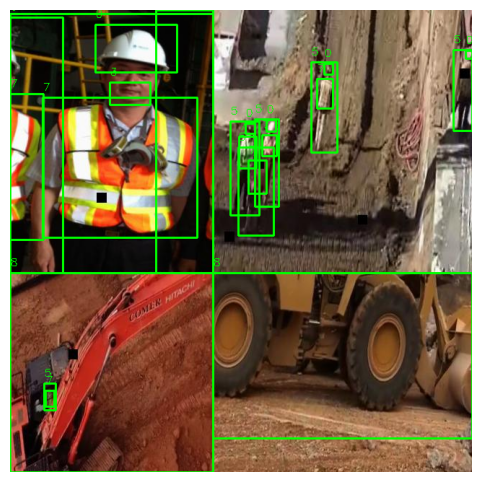

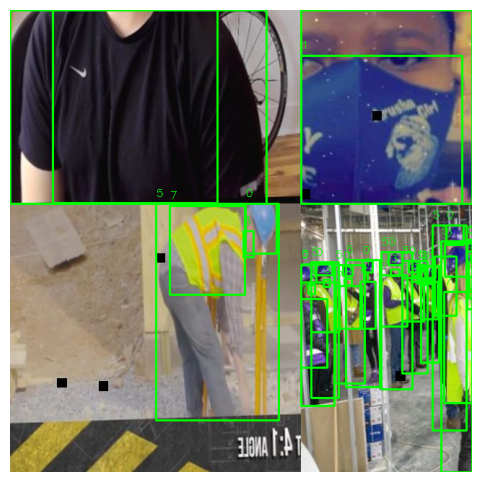

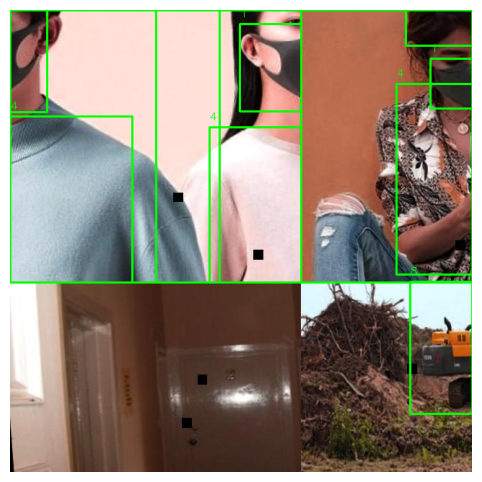

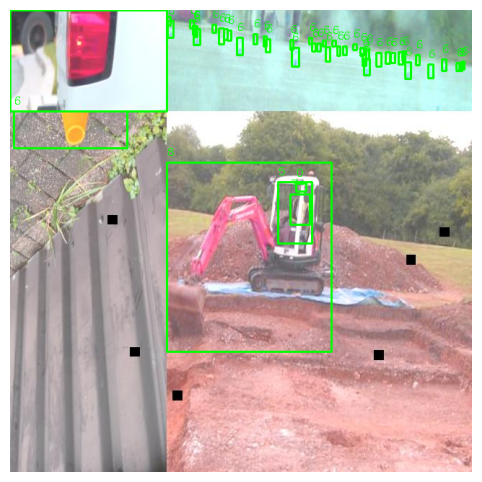

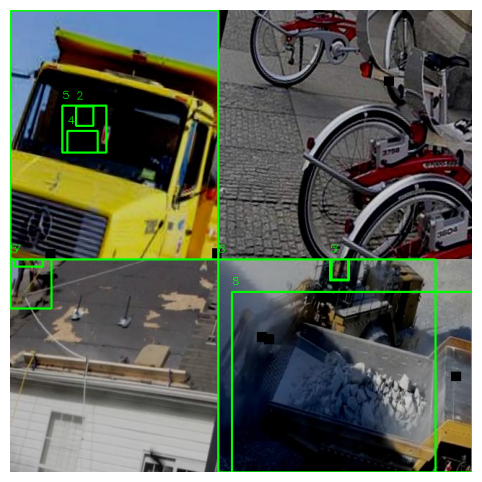

In [92]:
for _ in range(5):
    sample_img = os.path.join(IMAGES_DIR, 'train', random.choice(os.listdir(os.path.join(IMAGES_DIR, 'train'))))
    sample_lbl = sample_img.replace('images', 'labels').replace('.jpg', '.txt')
    visualize_sample(sample_img, sample_lbl)

# **Membuat file data.yaml untuk YOLO**

In [97]:
# Menulis file data.yaml
with open(os.path.join(OUTPUT_DIR, "data.yaml"), "w") as f:
    f.write(f"""
    train: {IMAGES_DIR}/train
    val: {IMAGES_DIR}/val

    nc: 10
    names: ["Hardhat","Mask","NO-Hardhat","NO-Mask","NO-Safety Vest","Person","Safety Cone","Safety Vest","machinery","vehicle"]
    """)

# **Model Training Dan Evaluasi**

In [98]:
# Load model
model = YOLO('yolov8n.yaml')

In [101]:
# Train model
model.train(
    data=os.path.join(OUTPUT_DIR,'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=32,
    project=OUTPUT_DIR,
    name="construction_site_safety_detection_model",
    verbose=True
)

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=construction_site_safety_detection_model5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /content/working/yolo_dataset/labels/train.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/working/yolo_dataset/images/train/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: /content/working/yolo_dataset/images/train/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 371.3±58.4 MB/s, size: 52.1 KB)


val: Scanning /content/working/yolo_dataset/labels/val.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/working/yolo_dataset/construction_site_safety_detection_model5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/working/yolo_dataset/construction_site_safety_detection_model5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.08G      3.436      4.411       4.14        373        640: 100%|██████████| 82/82 [00:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        697   0.000257      0.046   0.000236    6.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.08G      3.006      3.796      3.492        278        640: 100%|██████████| 82/82 [00:46<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697    0.00245      0.111    0.00204   0.000517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.08G      2.369      3.352      2.814        282        640: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

                   all        114        697      0.606     0.0217    0.00591    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.08G      1.982       3.04      2.423        293        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        114        697      0.518     0.0549     0.0133    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.08G      1.801      2.865      2.242        217        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]

                   all        114        697      0.329      0.059     0.0146    0.00444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.08G      1.715      2.771      2.136        303        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697       0.29     0.0539     0.0219    0.00707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       6.6G      1.659      2.673       2.07        308        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        697      0.366     0.0998     0.0273    0.00942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.61G      1.617      2.617      2.017        247        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all        114        697      0.329     0.0962     0.0474     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.61G      1.591      2.567      1.984        268        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        114        697      0.284      0.155      0.102     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.61G      1.564      2.514      1.945        237        640: 100%|██████████| 82/82 [00:41<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all        114        697      0.326      0.159      0.098     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.18G      1.544      2.471      1.923        183        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        114        697      0.549      0.141      0.109     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.18G      1.525      2.424      1.904        203        640: 100%|██████████| 82/82 [00:40<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        114        697      0.503       0.18      0.155     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.18G      1.512      2.376      1.876        328        640: 100%|██████████| 82/82 [00:41<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697      0.444      0.208      0.185     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       7.8G      1.499      2.369      1.864        299        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        697      0.452      0.208       0.17     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.46G      1.481      2.308      1.841        280        640: 100%|██████████| 82/82 [00:40<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all        114        697      0.418      0.203      0.182     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.51G      1.466      2.276      1.831        333        640: 100%|██████████| 82/82 [00:41<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        114        697      0.477      0.236      0.213     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.51G       1.45      2.254      1.813        311        640: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        114        697      0.449      0.237      0.224     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.77G      1.446      2.231      1.803        292        640: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all        114        697      0.498      0.271      0.276      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.02G      1.437       2.18      1.784        214        640: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697       0.54      0.282      0.284      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.03G      1.418       2.17      1.769        243        640: 100%|██████████| 82/82 [00:42<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        114        697      0.418      0.275      0.263      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.04G      1.419      2.136      1.761        299        640: 100%|██████████| 82/82 [00:41<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        114        697      0.519      0.262      0.286      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.04G      1.393      2.092      1.741        209        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        697      0.426       0.29      0.262      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.04G      1.404      2.076      1.736        267        640: 100%|██████████| 82/82 [00:42<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        697      0.549      0.291      0.323      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.67G      1.388      2.061      1.727        231        640: 100%|██████████| 82/82 [00:41<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        697      0.458      0.324      0.309      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.67G      1.388      2.033      1.721        230        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        114        697      0.565      0.333      0.353      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.67G      1.392      2.013      1.722        248        640: 100%|██████████| 82/82 [00:43<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        697      0.503      0.363      0.367      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.68G      1.378      1.999      1.709        379        640: 100%|██████████| 82/82 [00:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        114        697      0.556      0.337      0.351      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.68G      1.368      1.972      1.699        267        640: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        697      0.559       0.34       0.36      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.69G      1.365      1.973      1.696        293        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        697      0.591      0.361       0.37      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       6.7G      1.356      1.937      1.681        345        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        697      0.657      0.324      0.368      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.7G      1.351      1.923      1.677        151        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]

                   all        114        697      0.654      0.348      0.393      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       6.7G       1.35      1.912       1.67        316        640: 100%|██████████| 82/82 [00:42<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697      0.503      0.359      0.343      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.72G      1.341      1.893      1.668        251        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        697      0.575       0.36      0.384      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.72G      1.321      1.867      1.652        244        640: 100%|██████████| 82/82 [00:44<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        697      0.631      0.397      0.418      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.96G      1.331      1.865      1.657        235        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        697      0.704       0.36      0.418      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.79G      1.322      1.846      1.645        318        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all        114        697       0.64      0.367      0.418      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.81G      1.326      1.826      1.646        253        640: 100%|██████████| 82/82 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        697        0.7      0.386      0.438      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.82G      1.312      1.813      1.638        259        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        114        697      0.613      0.396      0.433      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.83G      1.308      1.805      1.634        338        640: 100%|██████████| 82/82 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        114        697      0.677       0.38       0.43      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.83G      1.306      1.794      1.631        235        640: 100%|██████████| 82/82 [00:41<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        697      0.656      0.378      0.437      0.199


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.84G      1.342      1.768      1.658        180        640: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        114        697      0.617      0.393      0.428      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.84G      1.329      1.712      1.648        137        640: 100%|██████████| 82/82 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        114        697      0.668      0.404      0.458      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.84G      1.325       1.69      1.641        151        640: 100%|██████████| 82/82 [00:38<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        114        697      0.645      0.394      0.445      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.84G      1.318      1.671      1.637        184        640: 100%|██████████| 82/82 [00:38<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        114        697      0.641      0.416      0.463      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.86G      1.317      1.669      1.629        188        640: 100%|██████████| 82/82 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        697      0.666      0.393      0.458      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.86G      1.309      1.651      1.624        169        640: 100%|██████████| 82/82 [00:39<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.683       0.44       0.48      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.86G      1.302      1.641      1.621        129        640: 100%|██████████| 82/82 [00:39<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697      0.661      0.441      0.481      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.88G      1.305      1.626      1.617        168        640: 100%|██████████| 82/82 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.671      0.439       0.48      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.88G      1.295      1.613      1.609        162        640: 100%|██████████| 82/82 [00:39<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697       0.66      0.435      0.478      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.88G      1.293      1.601      1.606        180        640: 100%|██████████| 82/82 [00:39<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all        114        697      0.657      0.442       0.48      0.231



50 epochs completed in 0.614 hours.
Optimizer stripped from /content/working/yolo_dataset/construction_site_safety_detection_model5/weights/last.pt, 6.3MB
Optimizer stripped from /content/working/yolo_dataset/construction_site_safety_detection_model5/weights/best.pt, 6.3MB

Validating /content/working/yolo_dataset/construction_site_safety_detection_model5/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


                   all        114        697       0.66      0.442       0.48      0.231
               Hardhat         42         79      0.759      0.544      0.586      0.332
                  Mask         19         21      0.777       0.81      0.786      0.391
            NO-Hardhat         37         69      0.791      0.329      0.416      0.159
               NO-Mask         44         74      0.508      0.223      0.255     0.0929
        NO-Safety Vest         56        106      0.602      0.302      0.361       0.17
                Person         84        166      0.658      0.429      0.493      0.217
           Safety Cone         13         44      0.723      0.591      0.618      0.308
           Safety Vest         28         41      0.757      0.561      0.599      0.324
             machinery         26         55      0.445      0.491      0.499      0.228
               vehicle         16         42      0.578      0.143      0.185     0.0933
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e9e3f648310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [102]:
metrics = model.val(data='/content/working/yolo_dataset/data.yaml',verbose=False)
print(metrics)

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1495.0±365.3 MB/s, size: 59.5 KB)


val: Scanning /content/working/yolo_dataset/labels/val.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all        114        697      0.657      0.442      0.479      0.231
Speed: 3.8ms preprocess, 8.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/working/yolo_dataset/construction_site_safety_detection_model52
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e9ead9a02d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.

# **Visualisasi Deteksi Objek pada Gambar Pengujian**


image 1/1 /content/working/yolo_dataset/images/test/maksssksksss17_png_jpg.rf.f685b497756b1facbf3d4c2d2d22c0d2.jpg: 640x640 1 Mask, 1 NO-Hardhat, 2 Persons, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


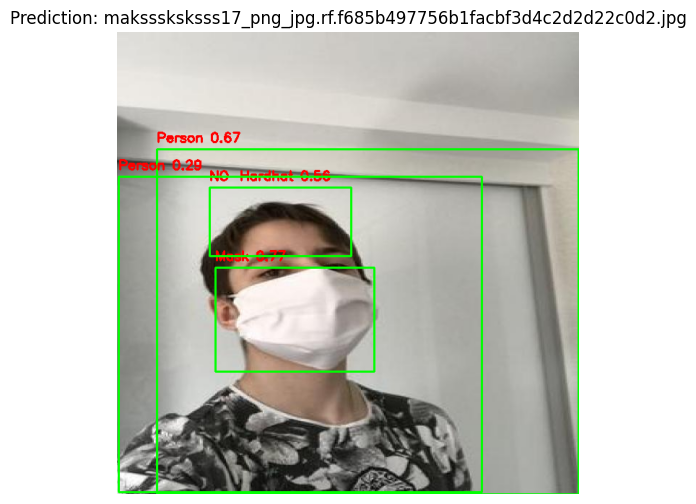


image 1/1 /content/working/yolo_dataset/images/test/autox3_mp4-187_jpg.rf.8340e2bd65afade3fb0d3194eadc5796.jpg: 640x640 5 Safety Cones, 2 vehicles, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


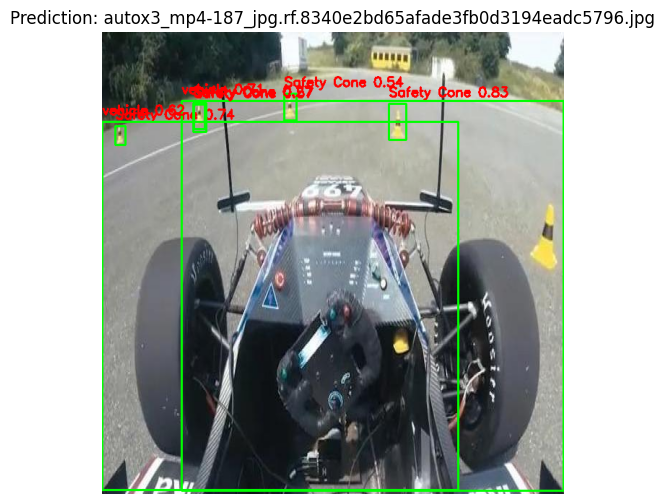


image 1/1 /content/working/yolo_dataset/images/test/maksssksksss17_png_jpg.rf.f685b497756b1facbf3d4c2d2d22c0d2.jpg: 640x640 1 Mask, 1 NO-Hardhat, 2 Persons, 26.0ms
Speed: 2.6ms preprocess, 26.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


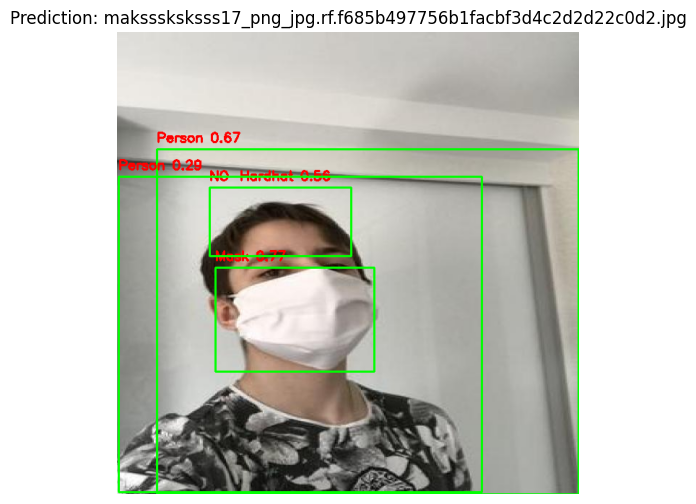


image 1/1 /content/working/yolo_dataset/images/test/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 (no detections), 52.0ms
Speed: 9.2ms preprocess, 52.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


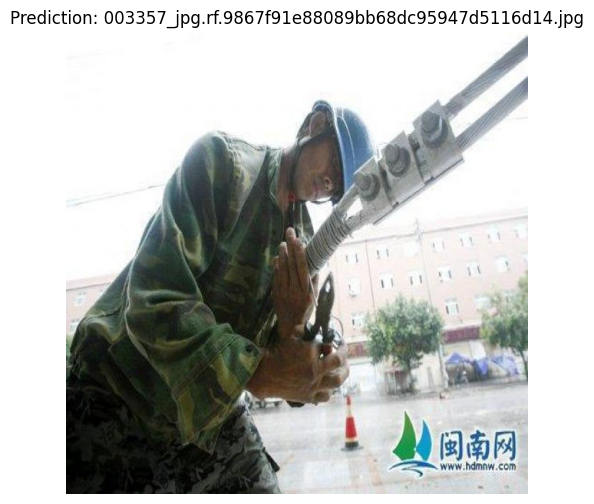


image 1/1 /content/working/yolo_dataset/images/test/construction-597-_jpg.rf.e18e918aae0aeecfdf8348513636d344.jpg: 640x640 2 machinerys, 63.5ms
Speed: 3.7ms preprocess, 63.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


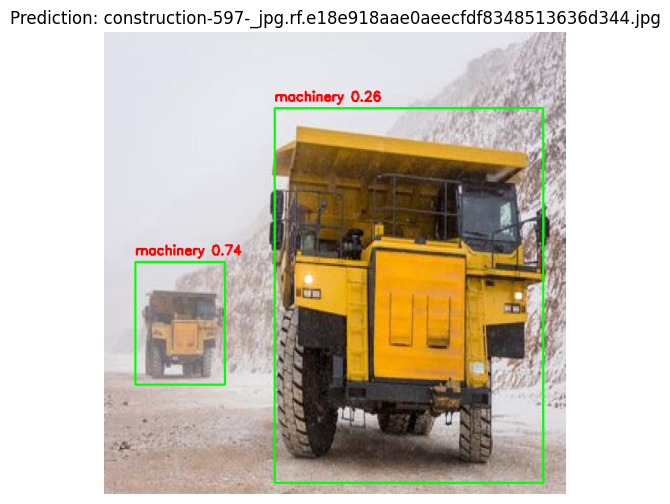


image 1/1 /content/working/yolo_dataset/images/test/RPReplay_Final1667001201_MP4-100_jpg.rf.9a1b50c4301c53b3ae534c6353337df9.jpg: 640x640 1 Mask, 1 NO-Hardhat, 3 NO-Safety Vests, 2 Persons, 26.5ms
Speed: 4.8ms preprocess, 26.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


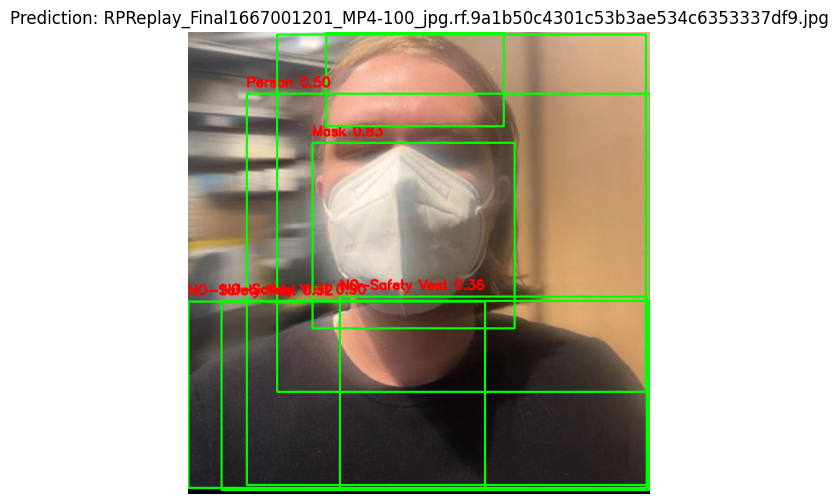


image 1/1 /content/working/yolo_dataset/images/test/IMG_0871_mp4-11_jpg.rf.432092b53ebeb84f4b9b27b40343c9aa.jpg: 640x640 1 Mask, 1 NO-Hardhat, 1 NO-Safety Vest, 1 Person, 23.2ms
Speed: 5.5ms preprocess, 23.2ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)


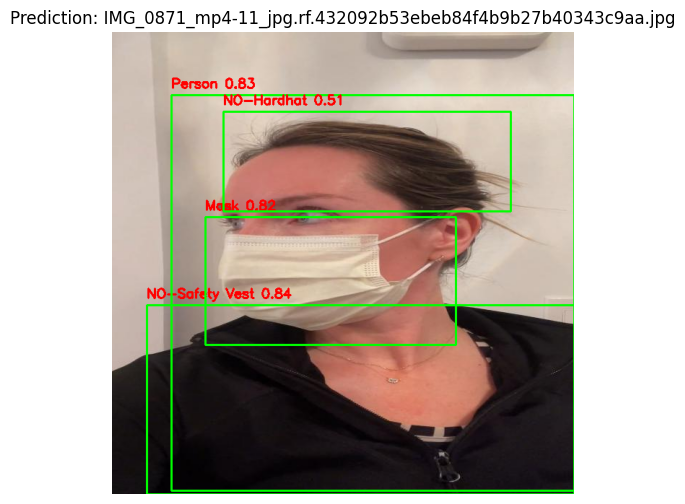


image 1/1 /content/working/yolo_dataset/images/test/2008_008519_jpg.rf.1798c8eed7de04399a0e7e297b4b4c9e.jpg: 640x640 1 machinery, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


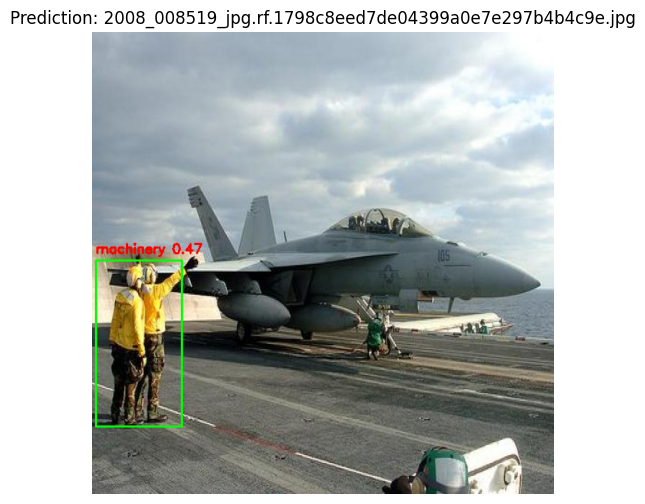


image 1/1 /content/working/yolo_dataset/images/test/IMG_0871_MOV-12_jpg.rf.36858a9d51613f9a39b7855b54dfa098.jpg: 640x640 1 Mask, 1 NO-Hardhat, 2 NO-Safety Vests, 2 Persons, 20.7ms
Speed: 2.7ms preprocess, 20.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


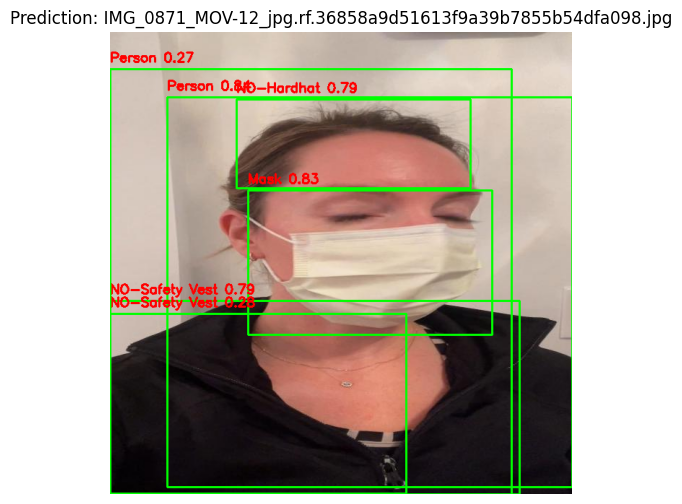


image 1/1 /content/working/yolo_dataset/images/test/IMG_0871_mp4-23_jpg.rf.03f872b1ed87ad7fadc85e09475ad37a.jpg: 640x640 1 Mask, 1 NO-Hardhat, 1 NO-Safety Vest, 1 Person, 17.2ms
Speed: 6.4ms preprocess, 17.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


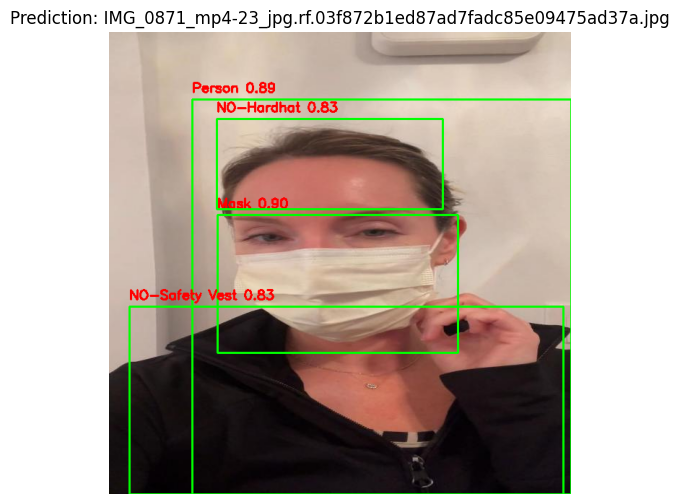

In [103]:
# Jalur untuk menguji gambar
test_dir = os.path.join(OUTPUT_DIR,'images','test')
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Menyimpan jumlah kelas dan skor kepercayaan diri
class_counter = Counter()
confidence_scores = defaultdict(list)

# Memuat nama kelas dari model
class_names = model.names

# Menjalankan inferensi pada sampel N acak
for _ in range(10):
    image_file = random.choice(test_images)
    image_path = os.path.join(test_dir, image_file)
    result = model(image_path)[0]

    img = cv2.imread(image_path)

    for box in result.boxes:
        cls_id = int(box.cls[0])
        score = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_name = class_names[cls_id]
        label = f"{class_name} {score:.2f}"

        # Update stats
        class_counter[class_name] += 1
        confidence_scores[class_name].append(score)

        # Draw box + label
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        cv2.putText(img, label, (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.6, color=(0, 0, 255), thickness=2)

    # Show image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prediction: {image_file}")
    plt.show()

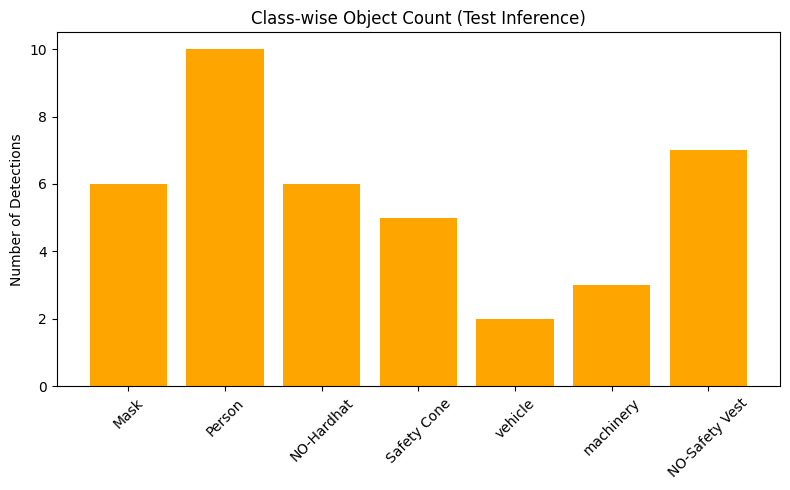

In [106]:
# Plot: Jumlah objek berdasarkan kelas
plt.figure(figsize=(8, 5))
plt.bar(class_counter.keys(), class_counter.values(), color='orange')
plt.title("Class-wise Object Count (Test Inference)")
plt.ylabel("Number of Detections")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Menyimpan model terbaik**

In [109]:
# Memuat model terbaik YOLOv8 yang terlatih
best_model_path = "/content/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.pt"
best_model = YOLO(best_model_path)

In [110]:
# Ekspor ke format ONNX
best_model.export(format='onnx',dynamic=True)

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (17.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 6.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 10.6s, saved as '/content/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.onnx' (11.6 MB)

Expo

'/content/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.onnx'